# Sentiment Analysis on Amazon Fine Food Reviews

## 📑 Table of Contents

1. [Introduction](#-Introduction)
2. [Step 1: Read in Data & NLTK Basics](#-Step-1-Read-in-Data--NLTK-Basics)
3. [Step 2: VADER Sentiment Scoring](#-Step-2-VADER-Sentiment-Scoring)
4. [Step 3: RoBERTa Pretrained Model](#-Step-3-RoBERTa-Pretrained-Model)
5. [Step 4: Comparing Sentiment Scores](#-Step-4-Combine-and-Compare)
6. [Step 5: Review Examples](#-Step-5-Review-Examples)
7. [Extra: HuggingFace Transformers Pipeline](#-Extra-The-Transformers-Pipeline)
8. [Conclusion](#-Conclusion)

## 💡 Introduction

In today's data-driven world, **understanding customer sentiment** is crucial for businesses to improve their products, services, and user experiences. One of the most powerful tools to achieve this is **Sentiment Analysis**, a branch of Natural Language Processing (NLP) that helps interpret the emotional tone behind textual data.

This project focuses on performing sentiment analysis using the **Amazon Fine Food Reviews** dataset. We aim to analyze how people feel about food products based on their reviews using **two major NLP techniques**:

1. **VADER (Valence Aware Dictionary and sEntiment Reasoner)** – A rule-based model designed for social media and review text.
2. **RoBERTa** – A transformer-based deep learning model pre-trained on large corpora and fine-tuned for sentiment classification.
3. **HuggingFace Sentiment Pipeline** – A quick implementation using pretrained models like DistilBERT.

Throughout this notebook, we:
- Perform **data cleaning and basic NLP tasks**
- Visualize sentiment distribution
- Apply and compare **VADER vs. RoBERTa models**
- Use transformer models to classify sentiments
- Identify **mismatches between model predictions and actual ratings**

This analysis not only showcases the power of modern NLP techniques but also helps us understand how machine learning can uncover hidden insights in text data.


# Step 1 – Imports and Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from tqdm import tqdm

In [3]:
# Read in data
df = pd.read_csv('C:\\Users\\tanis\\Reviews.csv.zip')
print(df.shape)

(568454, 10)


In [4]:
df = df.head(500)
print(df.shape)

(500, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA: Review Distribution

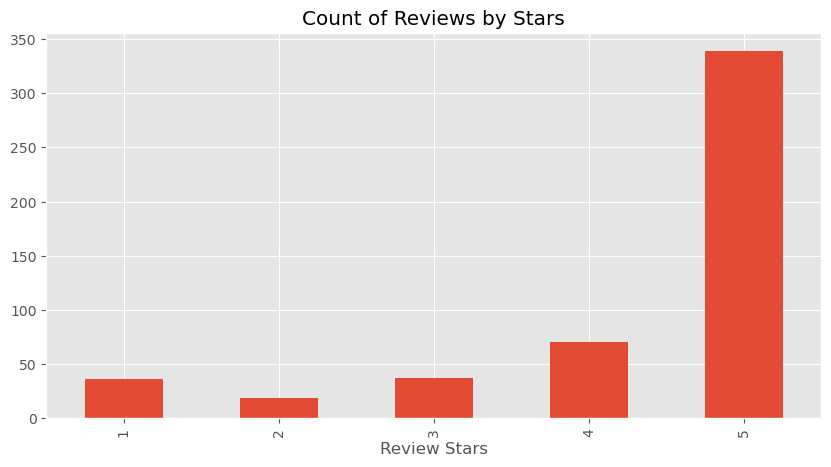

In [6]:
# EDA Plot

ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                                  title='Count of Reviews by Stars',
                                                  figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK Tokenization and Entity Recognition

In [7]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [13]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [15]:
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [17]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [19]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 2: VADER Sentiment Scoring
Using a lexicon-based approach to compute polarity scores.

## VADER

In [21]:
!pip install nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
sia = SentimentIntensityAnalyzer()

In [25]:
text = df['Text'][50]
score = sia.polarity_scores(text)
print(score)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


In [27]:
if score['compound'] >= 0.05:
    print("Positive 😊")
elif score['compound'] <= -0.05:
    print("Negative 😞")
else:
    print("Neutral 😐")

Negative 😞


In [29]:
# Test examples
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [31]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

## HuggingFace Transformers: RoBERTa Model

In [33]:
# RoBERTa via Pipeline
!pip install transformers
!pip install torch
from transformers import pipeline

In [34]:
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


In [35]:
text = df['Text'][50]
result = classifier(text)
print(result)

[{'label': 'LABEL_0', 'score': 0.9763551354408264}]


In [39]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

In [41]:
predicted_label = label_map[result[0]['label']]
confidence = result[0]['score']
print(f"Predicted Sentiment: {predicted_label} (Confidence: {confidence:.2f})")

Predicted Sentiment: Negative (Confidence: 0.98)


In [43]:
label = result[0]['label']
score = result[0]['score']
print(f"Text: {text}")
print(f"Sentiment: {label}")
print(f"Confidence Score: {score:.2f}")

Text: This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
Sentiment: LABEL_0
Confidence Score: 0.98


In [45]:
if label == 'LABEL_0':
    print("🟥 Negative Sentiment Detected.")
elif label == 'LABEL_1':
    print("🟨 Neutral Sentiment Detected.")
elif label == 'LABEL_2':
    print("🟩 Positive Sentiment Detected.")

🟥 Negative Sentiment Detected.


## Plot VADER Results

In [47]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(res).T.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 675.46it/s]


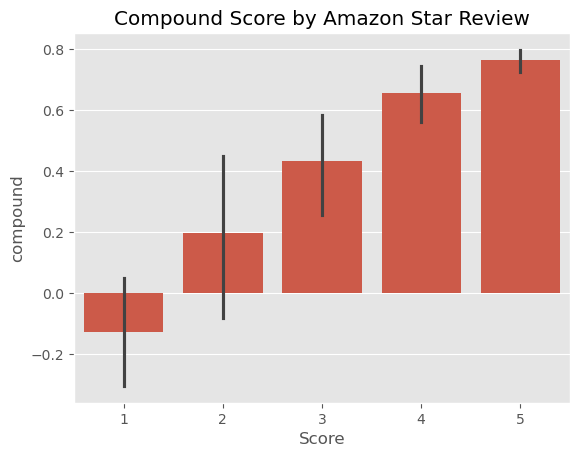

In [49]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

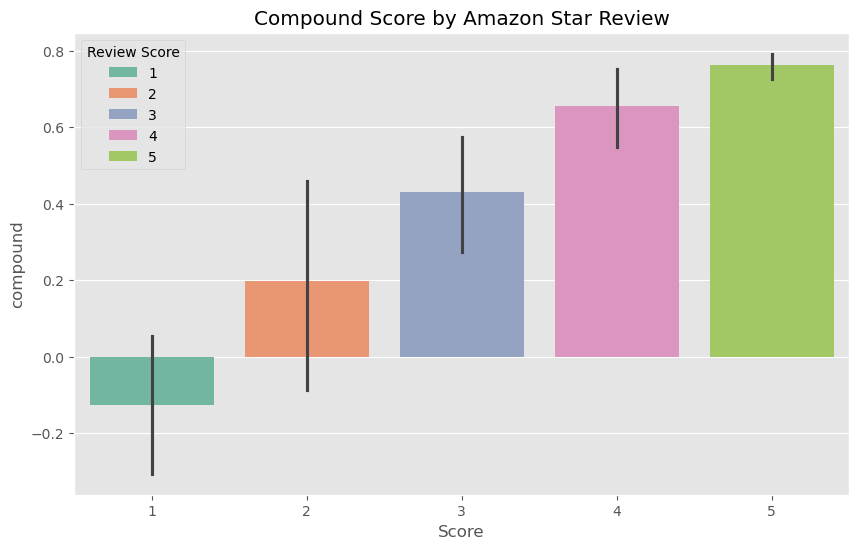

In [51]:
# Color Palette Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score', dodge=False, palette='Set2')
ax.set_title('Compound Score by Amazon Star Review')
plt.legend(title='Review Score')
plt.show()

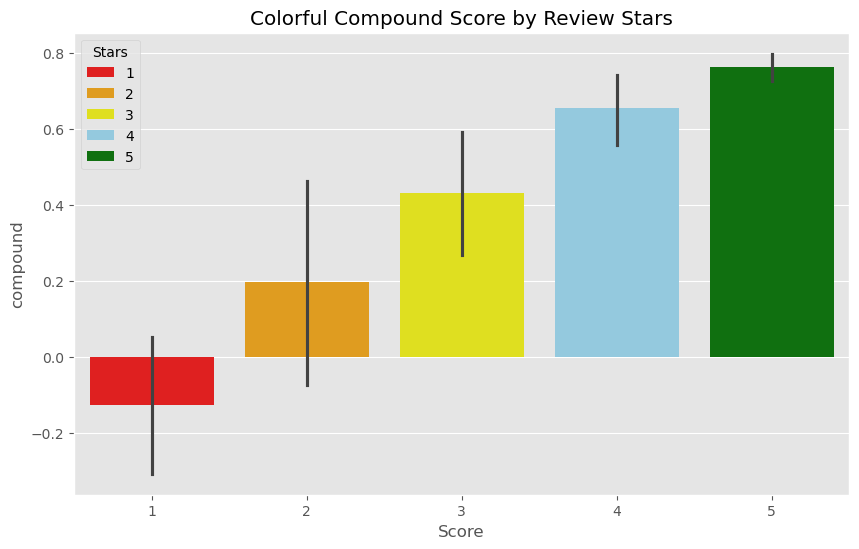

In [53]:
# Colorful Bar Chart
palette = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'skyblue', 5: 'green'}

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score', dodge=False, palette=palette)
ax.set_title('Colorful Compound Score by Review Stars')
plt.legend(title='Stars')
plt.show()

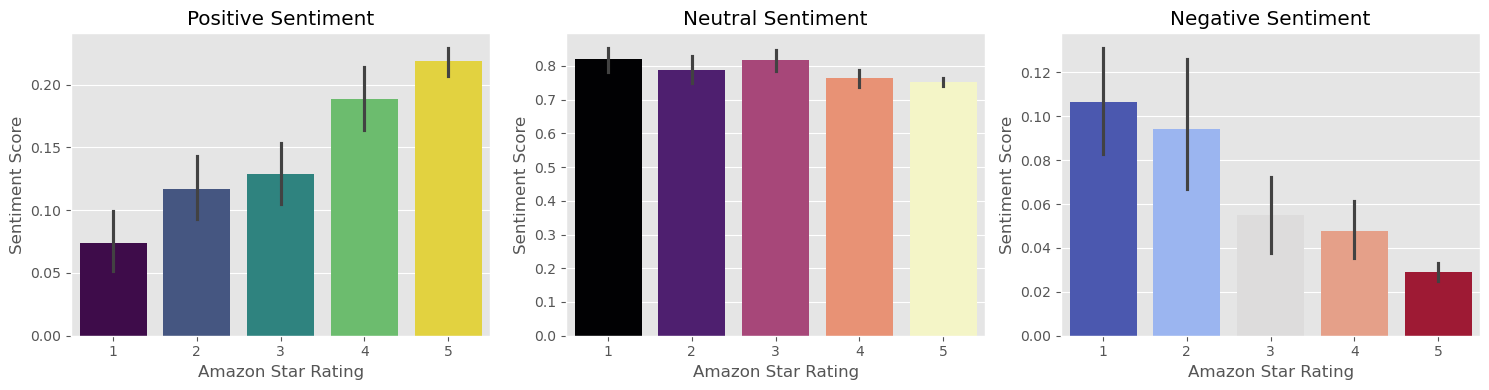

In [55]:
# Subplots for Pos/Neu/Neg
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0], hue='Score', palette='viridis')
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1], hue='Score', palette='magma')
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2], hue='Score', palette='coolwarm')

axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')

for ax in axs:
    ax.legend_.remove()
    ax.set_xlabel('Amazon Star Rating')
    ax.set_ylabel('Sentiment Score')

plt.tight_layout()
plt.show()

## Step 3: RoBERTa Pretrained Model (Manual Method)

In [57]:
# RoBERTa Model Load
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [59]:
# Score Example
print(example)
sia.polarity_scores(example)

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = softmax(output[0][0].detach().numpy())
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573692}


In [61]:
# Define Function
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output.logits.softmax(dim=1).detach().numpy()[0]
    return {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

In [63]:
# Run Both Models
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}
        
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
        
    except Exception as e:
        print(f'⚠️ Broke for id {myid} | Error: {e}')

results_df = pd.DataFrame(res).T.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


## Step 4: Compare VADER and RoBERTa Score

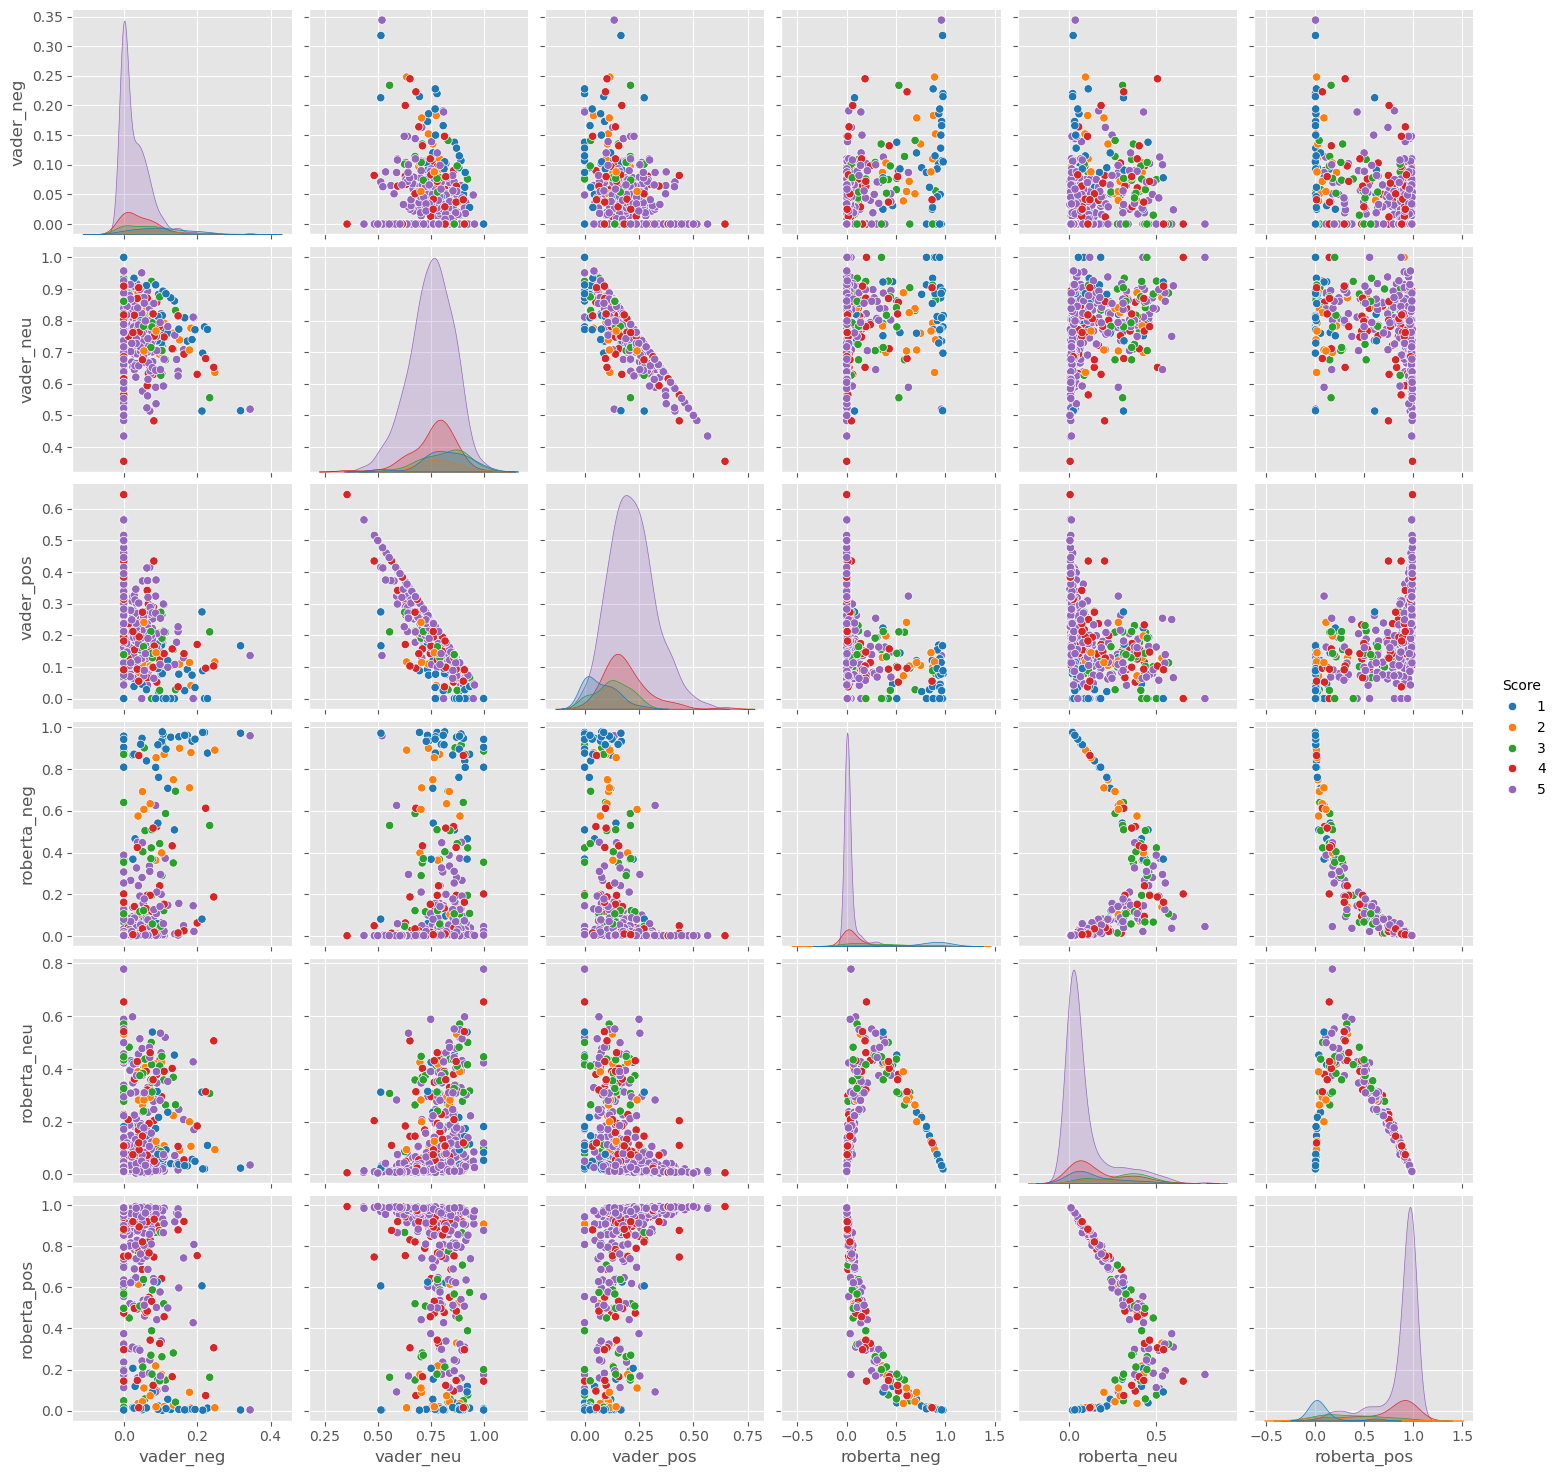

In [65]:
# Pairplot
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

## Step 5: Review Mismatched Examples
Positive 1-Star & Negative 5-Star Reviews

In [67]:
# Positive Sentiment, Low Score
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [69]:
# Negative Sentiment, High Score
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: HuggingFace Sentiment Pipeline (DistilBERT)

In [71]:
from transformers import pipeline

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
sent_pipeline = pipeline("sentiment-analysis", model=model_name, revision="714eb0f")

sent_pipeline('I love Cheese cakes!')
sent_pipeline('She is charming!')
sent_pipeline('Yeah')

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9993269443511963}]

## 📝 Conclusion

In this project, we explored and compared multiple techniques for performing **Sentiment Analysis** on customer reviews from the Amazon Fine Food Reviews dataset.

🔍 We used three different approaches:
1. **VADER (Valence Aware Dictionary and sEntiment Reasoner)** – a rule-based sentiment analysis tool specifically tuned for social media text.
2. **RoBERTa** – a state-of-the-art transformer model fine-tuned on sentiment data using HuggingFace.
3. **DistilBERT Pipeline** – another efficient transformer-based model for sentiment classification.

📊 Through data visualization and model predictions, we observed that:
- **VADER** performs well for shorter and direct sentences but can be biased toward neutral results in complex cases.
- **RoBERTa**, being a deep learning model, handles context better and gives more accurate sentiment for longer or nuanced reviews.
- The models occasionally disagreed with actual star ratings, revealing **subjectivity in customer reviews**.

✅ In conclusion, **transformer-based models like RoBERTa clearly outperform traditional lexicon-based methods** in terms of capturing complex sentiments, though both have their unique advantages.

This project provides a strong foundation for real-world applications like **review monitoring, product feedback analysis, and customer satisfaction prediction**.

---